In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from adjustText import adjust_text

/home/jovyan/.mlspace/envs/salnikov_12_4/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
main_df = pd.read_csv('./main.csv')
main_df.head()

,Unnamed: 0,Feature,Classifier,ROC AUC,Accuracy,Correlation,Norm Confusion Matrix,Retrieval Calls,In-Accuracy_init_mean,In-Accuracy_bootstrap_mean,...,F1_bootstrap_mean,F1_CI_lower,F1_CI_higher,F1_std,Dataset,LLM Call,is_baseline,UC_rate,overconfidence,conservativeness
0,0,Perplexity,Logistic Regression,0.643,0.894,0.153,"[[0.0, 0.106], [0.0, 0.894]]",1.00,0.100,0.100,...,0.167,0.140,0.195,0.014,musique,2.00,0,1.000,0.000,0.106
1,1,Perplexity,KNN,0.600,0.894,0.153,"[[0.0, 0.106], [0.0, 0.894]]",1.00,0.100,0.100,...,0.167,0.140,0.195,0.014,musique,2.00,0,1.000,0.000,0.106
2,2,Perplexity,MLP,0.643,0.894,0.153,"[[0.0, 0.106], [0.0, 0.894]]",1.00,0.100,0.100,...,0.167,0.140,0.195,0.014,musique,2.00,0,1.000,0.000,0.106
3,3,Perplexity,Decision Tree,0.626,0.878,0.153,"[[0.006, 0.1], [0.022, 0.872]]",0.97,0.098,0.098,...,0.168,0.141,0.195,0.014,musique,1.97,0,0.972,0.022,0.100
4,4,Perplexity,Threshold,0.643,0.894,0.153,"[[0.002, 0.104], [0.002, 0.892]]",1.00,0.098,0.098,...,0.165,0.138,0.192,0.014,musique,2.00,0,0.996,0.002,0.104


/home/jovyan/.mlspace/envs/salnikov_12_4/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.
/tmp/ipykernel_1239321/1374346693.py:25: RuntimeWarning: divide by zero encountered in log2
  return np.where(x <= 5, x, 5 + np.log2(x - 4))
/tmp/ipykernel_1239321/1374346693.py:25: RuntimeWarning: invalid value encountered in log2
  return np.where(x <= 5, x, 5 + np.log2(x - 4))
/home/jovyan/.mlspace/envs/salnikov_12_4/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_1239321/1374346693.py:25: RuntimeWarning: divide by zero encountered in log2
  return np.where(x <= 5, x, 5 + np.

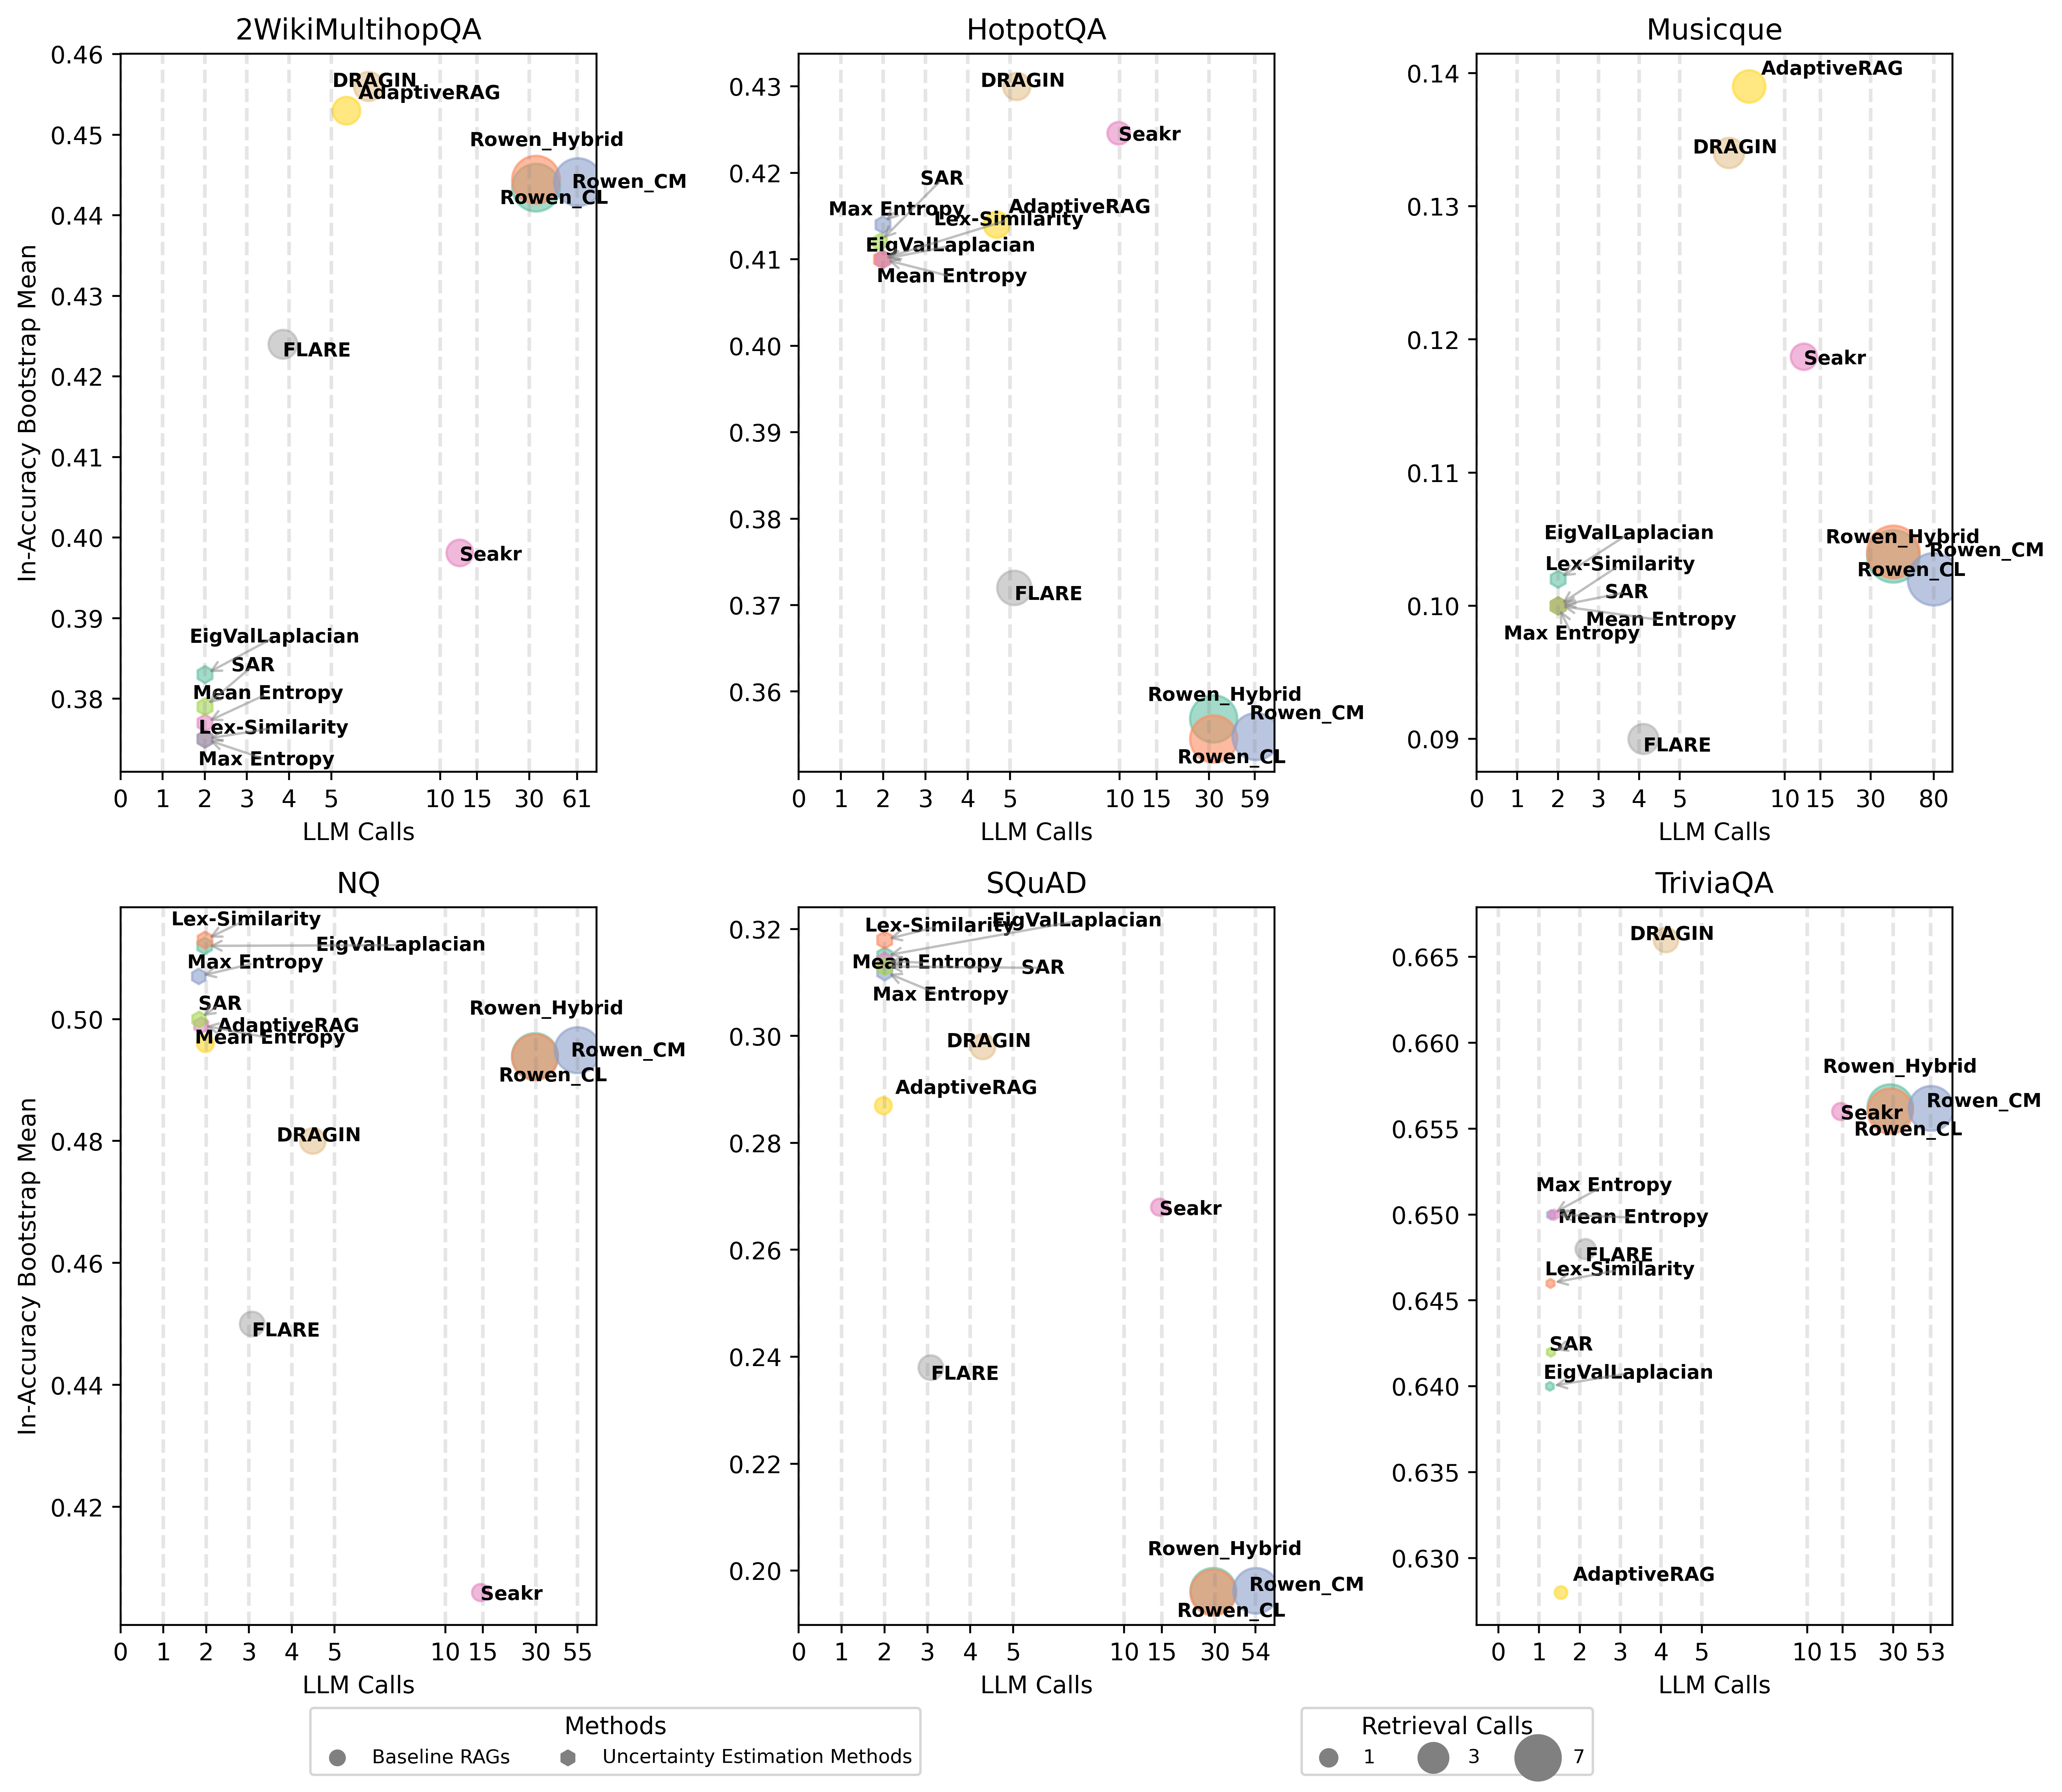

In [3]:
def plot_performance_scatter_compressed(df, datasets):
    dataset_beutifull_map = {
        'nq': 'NQ',
        'trivia': 'TriviaQA',
        'squad': 'SQuAD',
        'hotpotqa': 'HotpotQA',
        '2wikimultihopqa': '2WikiMultihopQA',
        'musique': 'Musicque',
    }
    # Calculate number of rows needed for 3 columns
    n_cols = 3
    n_rows = (len(datasets) + n_cols - 1) // n_cols
    
    # Create subplots grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 5*n_rows), dpi=500)
    axes = axes.flatten() if n_rows > 1 else [axes] if len(datasets) == 1 else axes
    
    for ax, dataset in zip(axes, datasets):
        plt.sca(ax)
        dataset_df = df[df['Dataset'] == dataset]
        x_col = 'MaxLLMCalls'
        
        # Create transformation for x-axis values
        def transform_x(x):
            return np.where(x <= 5, x, 5 + np.log2(x - 4))
        
        # Transform the x values in the dataframe
        dataset_df = dataset_df.copy()
        dataset_df['transformed_x'] = transform_x(dataset_df[x_col])
        
        # Define feature groups and their markers
        circle_features = ['AdaptiveRAG', 'DRAGIN', 'FLARE', 'Rowen_CM', 'Rowen_CL', 'Rowen_Hybrid', 'Seakr']
        star_features = ['EigValLaplacian', 'Lex-Similarity', 'Max Entropy', 'Mean Entropy', 'SAR']
        dataset_df = dataset_df[dataset_df['Feature'].isin(circle_features + star_features)]

        # Get color palette
        colors = sns.color_palette("Set2")
        used_positions = []
        
        # Plot each group with different markers
        texts = []
        for i, feature in enumerate(star_features + circle_features):
            mask = dataset_df['Feature'] == feature
            marker = 'o' if feature in circle_features else 'h'
            
            # Get data for this feature
            feature_data = dataset_df[mask].copy()
                
            # Create scatter plot
            scatter = plt.scatter(feature_data['transformed_x'], 
                                feature_data['MaxInaccuracyBootstrap'],
                                s=feature_data['MaxRetrievalCalls'] * 50,
                                marker=marker,
                                color=colors[i % len(colors)],
                                alpha=0.6)
            
            # Add annotations
            for idx, row in feature_data.iterrows():
                x, y = row['transformed_x'], row['MaxInaccuracyBootstrap']
                
                if feature in star_features:
                    texts.append(plt.text(x, y, feature, fontsize=8, alpha=0.99, weight='bold'))
                else:
                    # Define possible annotation positions
                    positions = [(5, 5), (-15, 0), (0, -5), (0, -5), (0, -3), (0, 3), 
                               (-5, -10), (5, 0), (5, 0), (4, 0), (2, 0)]
                    
                    if 'rowen' in feature.lower():
                        positions = [(15, 0), (-15, -10), (-45, 15), (-15, 15)]
                    
                    # Find best position
                    best_pos = next((pos for pos in positions if pos not in used_positions), (10, 10))
                    used_positions.append(best_pos)
                    
                    plt.annotate(f"{feature}",
                                (x, y),
                                xytext=best_pos,
                                textcoords='offset points',
                                fontsize=8,
                                alpha=0.99,
                                weight='bold')
        # Adjust text positions for star features
        adjust_text(texts,
                   expand_points=(0.1, 0.1),
                   arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5),
                   force_points=(0.5, 0.5),
                   max_move=(25, 25),
                   fontweight='bold')
        # Customize x-axis ticks
        max_x = dataset_df[x_col].max()
        original_ticks = [0, 1, 2, 3, 4, 5, 10, 15, 30, int(max_x)]
        transformed_ticks = transform_x(np.array(original_ticks))
        plt.xticks(transformed_ticks, original_ticks)
        
        # Add grid lines at original positions
        for tick in transformed_ticks:
            plt.axvline(x=tick, color='gray', linestyle='--', alpha=0.2)
        
        plt.xlabel('LLM Calls')
        if ax in axes[::n_cols]:  # Add y-label to leftmost plots in each row
            plt.ylabel('In-Accuracy Bootstrap Mean')
            
        plt.title(f'{dataset_beutifull_map[dataset]}')

    # Hide empty subplots if any
    for ax in axes[len(datasets):]:
        ax.set_visible(False)

    # Add legends for all subplots at the bottom
    marker_legend = [
        plt.scatter([], [], marker='o', color='gray', label='Baseline RAGs'),
        plt.scatter([], [], marker='h', color='gray', label='Uncertainty Estimation Methods')
    ]
    
    # Create separate legend handles for sizes
    size_legend = [
        plt.scatter([], [], marker='o', color='gray', s=50, label='1'),
        plt.scatter([], [], marker='o', color='gray', s=150, label='3'),
        plt.scatter([], [], marker='o', color='gray', s=350, label='7')
    ]

    # Create figure-level legends below the subplots
    fig = plt.gcf()
    fig.legend(
        handles=marker_legend,
        loc='center',
        bbox_to_anchor=(0.3, -0.01),
        fontsize=8,
        title='Methods',
        ncol=2
    )
    
    fig.legend(
        handles=size_legend,
        loc='center', 
        bbox_to_anchor=(0.7, -0.01),
        fontsize=8,
        title='Retrieval Calls',
        ncol=3
    )

    plt.tight_layout()
    return axes



_df = main_df.groupby(["Dataset", "Feature"]).agg(
    MaxInaccuracyBootstrap=("In-Accuracy_bootstrap_mean", 'max'),
    MaxInaccuracy=("In-Accuracy_init_mean", 'max'),
    MaxRetrievalCalls=("Retrieval Calls", 'max'),
    MaxLLMCalls=("LLM Call", 'max'),
).reset_index()

plot_performance_scatter_compressed(_df, _df['Dataset'].unique())
plt.savefig(f'InAccBootstrap_vs_LLMCalls_compressed.pdf', bbox_inches='tight', dpi=500)

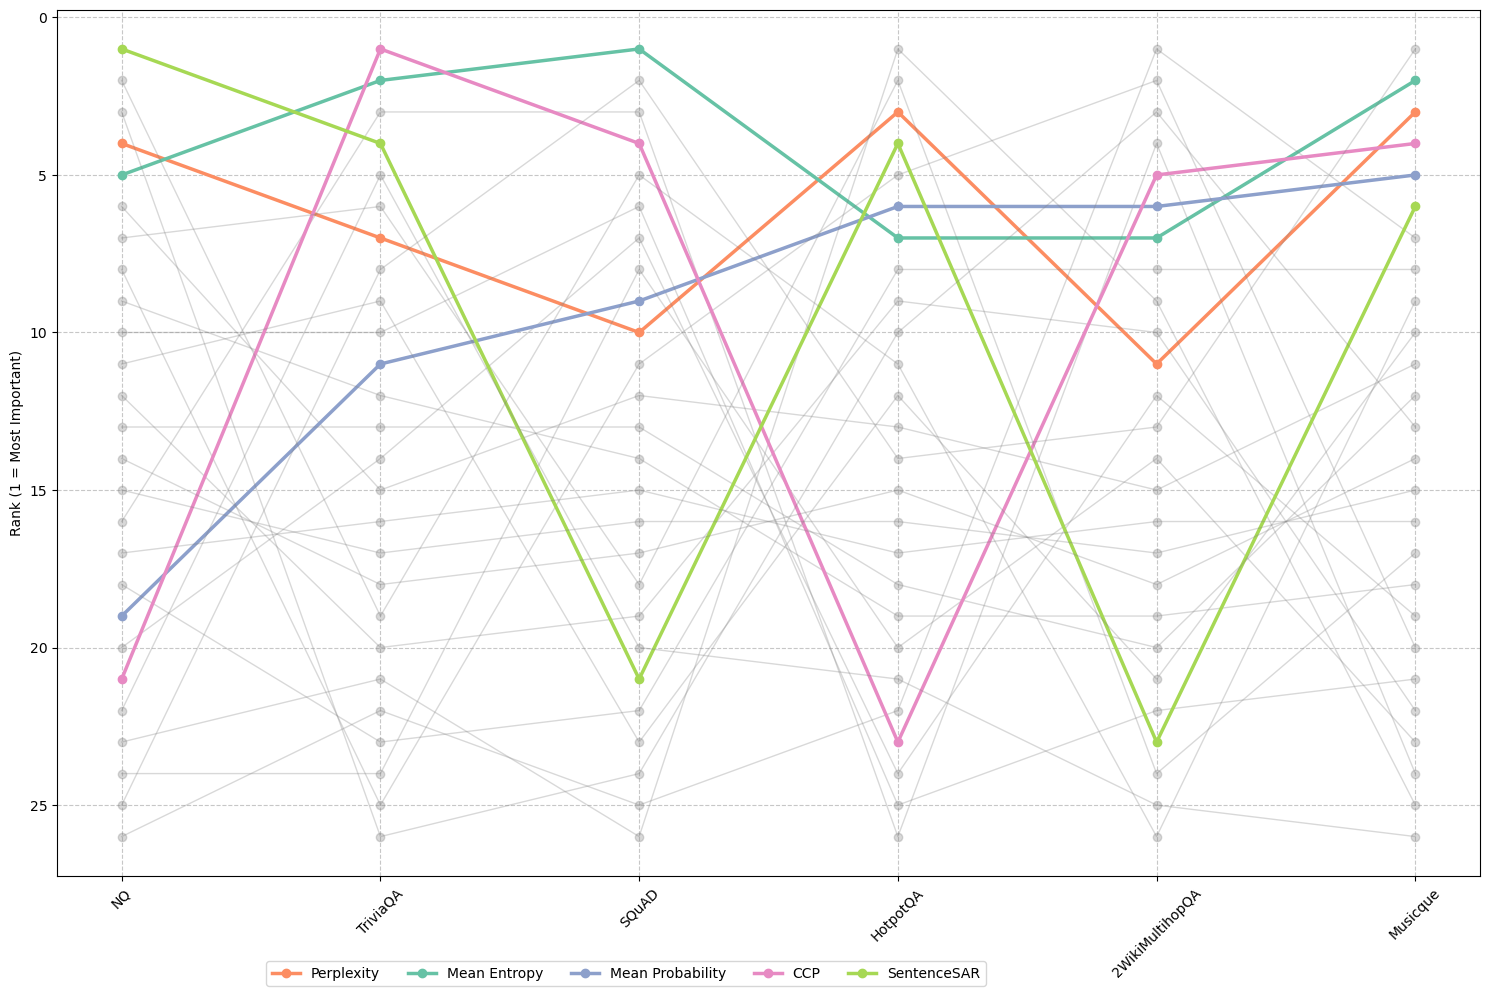

In [13]:
DATASET_BEUTIFULL_MAP = {
    's_nq': 'NQ',
    's_trivia': 'TriviaQA',
    's_squad': 'SQuAD',
    's_hotpotqa': 'HotpotQA',
    's_2wikimultihopqa': '2WikiMultihopQA',
    's_musique': 'Musicque',
}

def get_feature_rank_df(fi_df):
    # Get dataset columns
    dataset_cols = ['s_nq', 's_trivia', 's_squad', 's_hotpotqa', 's_2wikimultihopqa', 's_musique']

    # Calculate rankings for each dataset
    rank_df = pd.DataFrame()
    for col in dataset_cols:
        rank_df[col] = fi_df[col].rank(ascending=False)

    rank_df['mean_rank'] = rank_df.mean(axis=1)
    rank_df['Feature'] = fi_df['Feature']

    return rank_df

def plot_feature_importance_rankings(fi_df):
    # Get dataset columns
    dataset_cols = ['s_nq', 's_trivia', 's_squad', 's_hotpotqa', 's_2wikimultihopqa', 's_musique']

    rank_df = get_feature_rank_df(fi_df)

    # Sort features by mean rank to determine color coding
    top_features = rank_df.nsmallest(5, 'mean_rank')['Feature'].tolist()

    # Create line plot
    plt.figure(figsize=(15, 10))

    # Get beautified dataset names for x-axis
    x_labels = [DATASET_BEUTIFULL_MAP[col] for col in dataset_cols]

    # Get Set2 color palette
    colors = sns.color_palette("Set2")

    # Plot each feature
    for idx, feature in enumerate(fi_df['Feature']):
        if feature in top_features:
            plt.plot(x_labels, rank_df.loc[idx, dataset_cols], 
                    label=feature, linewidth=2.5, marker='o',
                    color=colors[top_features.index(feature)])
        else:
            plt.plot(x_labels, rank_df.loc[idx, dataset_cols], 
                    color='gray', alpha=0.3, linewidth=1, marker='o')

    plt.gca().invert_yaxis()  # Invert y-axis so rank 1 is at the top
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(bbox_to_anchor=(0.4, -0.09), loc='upper center', ncol=5)
    plt.ylabel('Rank (1 = Most Important)')
    plt.tight_layout()


fi_df = pd.read_csv('./FI_logreg.csv')
plot_feature_importance_rankings(fi_df)
plt.savefig(f"FI_rankings.pdf", bbox_inches='tight', dpi=500)

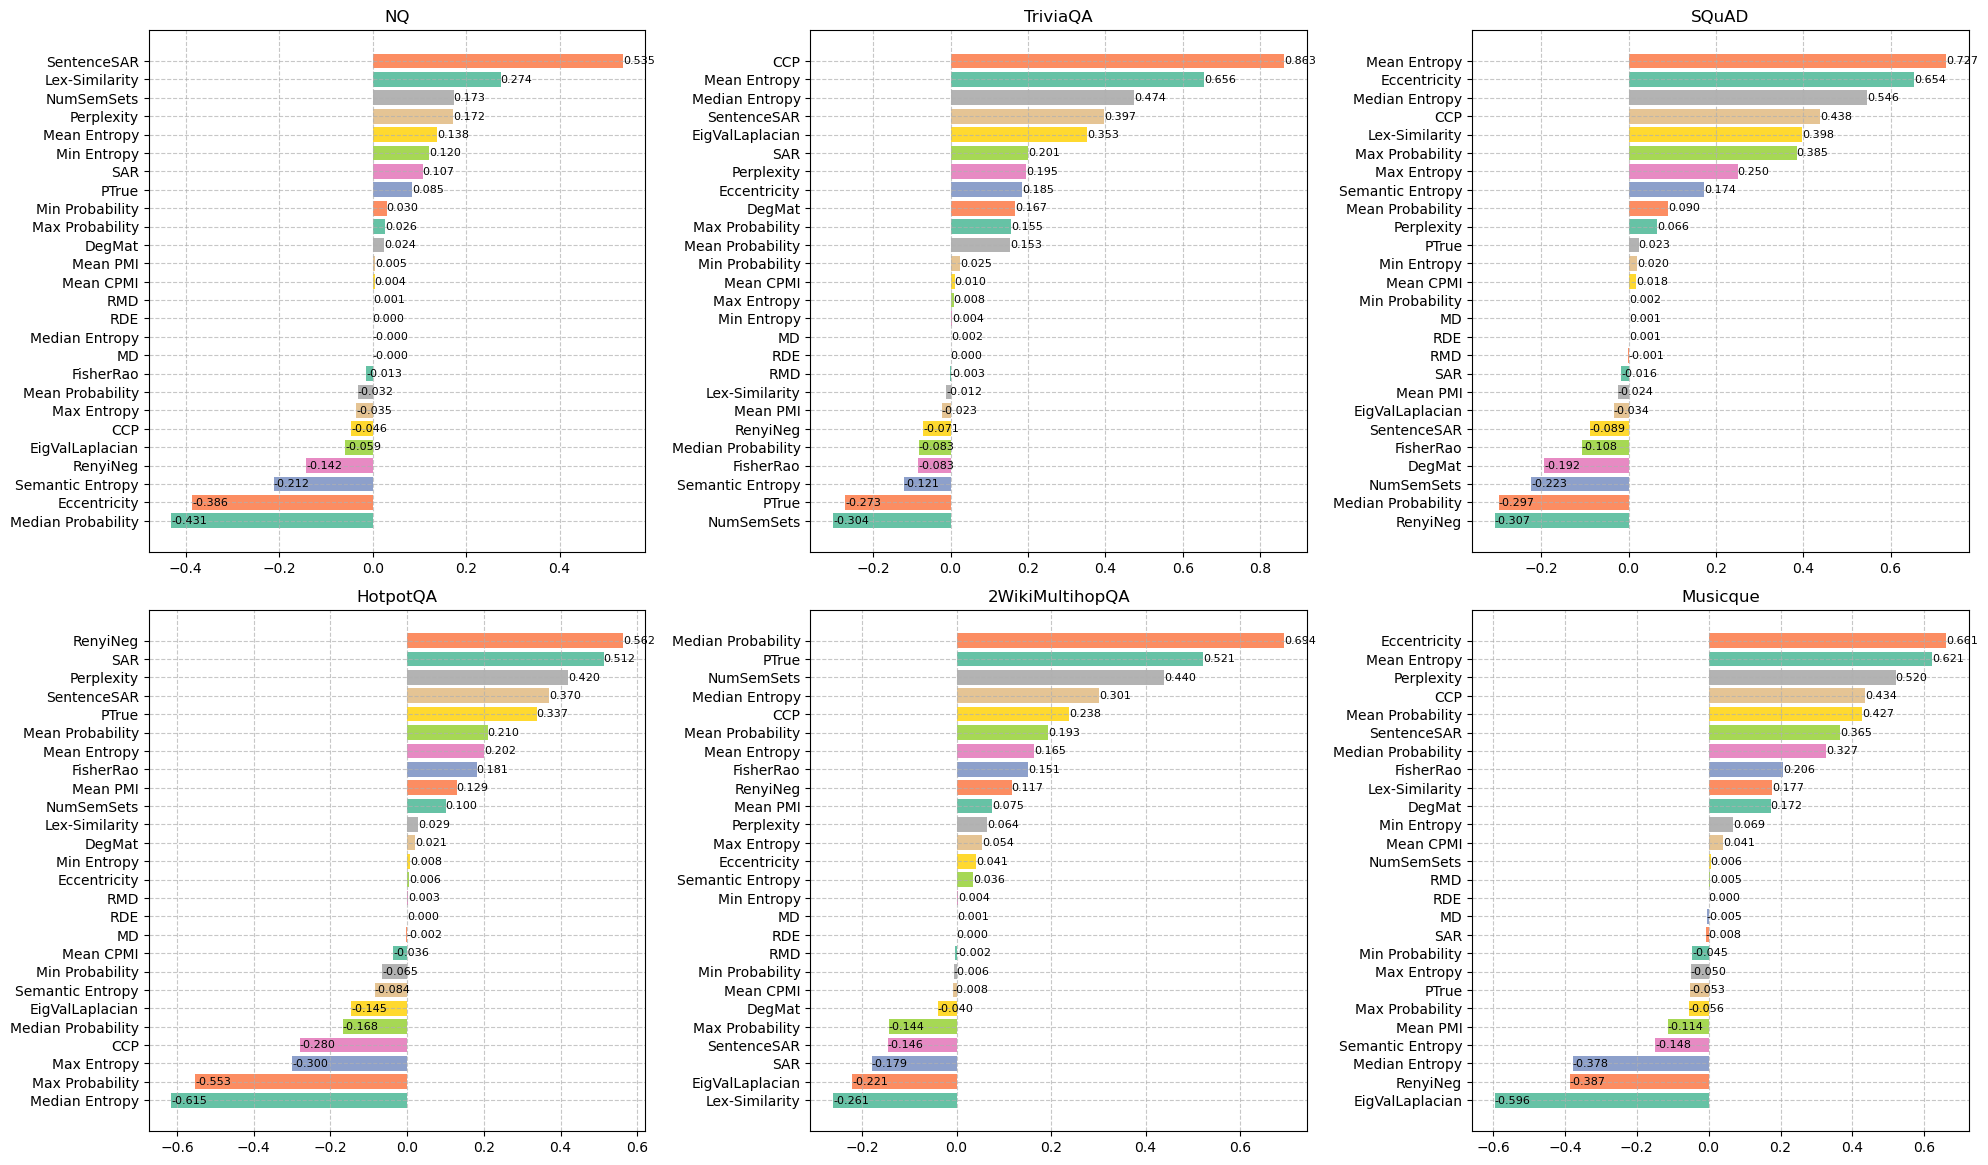

In [5]:
def plot_feature_importance_barcharts(fi_df):
    # Get dataset columns
    dataset_cols = ['s_nq', 's_trivia', 's_squad', 's_hotpotqa', 's_2wikimultihopqa', 's_musique']
    
    # Create subplot grid
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.ravel()
    
    # Get color palette
    colors = sns.color_palette("Set2")
    
    # Plot bar chart for each dataset
    for idx, col in enumerate(dataset_cols):
        # Sort features by importance
        dataset_fi = fi_df[['Feature', col]].sort_values(col, ascending=True)
        
        # Create bar chart
        bars = axes[idx].barh(dataset_fi['Feature'], dataset_fi[col], 
                            color=[colors[i % len(colors)] for i in range(len(dataset_fi))])
        
        # Customize plot
        axes[idx].set_title(DATASET_BEUTIFULL_MAP[col])
        axes[idx].grid(True, linestyle='--', alpha=0.7)
        
        # Add value labels on bars
        for bar in bars:
            width = bar.get_width()
            axes[idx].text(width, bar.get_y() + bar.get_height()/2,
                         f'{width:.3f}', 
                         ha='left', va='center', fontsize=8)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    # fig.suptitle('Feature Importance Across Datasets', fontsize=16, y=0.98)
    
# Plot and save
plot_feature_importance_barcharts(fi_df)
plt.savefig(f"FI_barcharts.pdf", bbox_inches='tight', dpi=500)


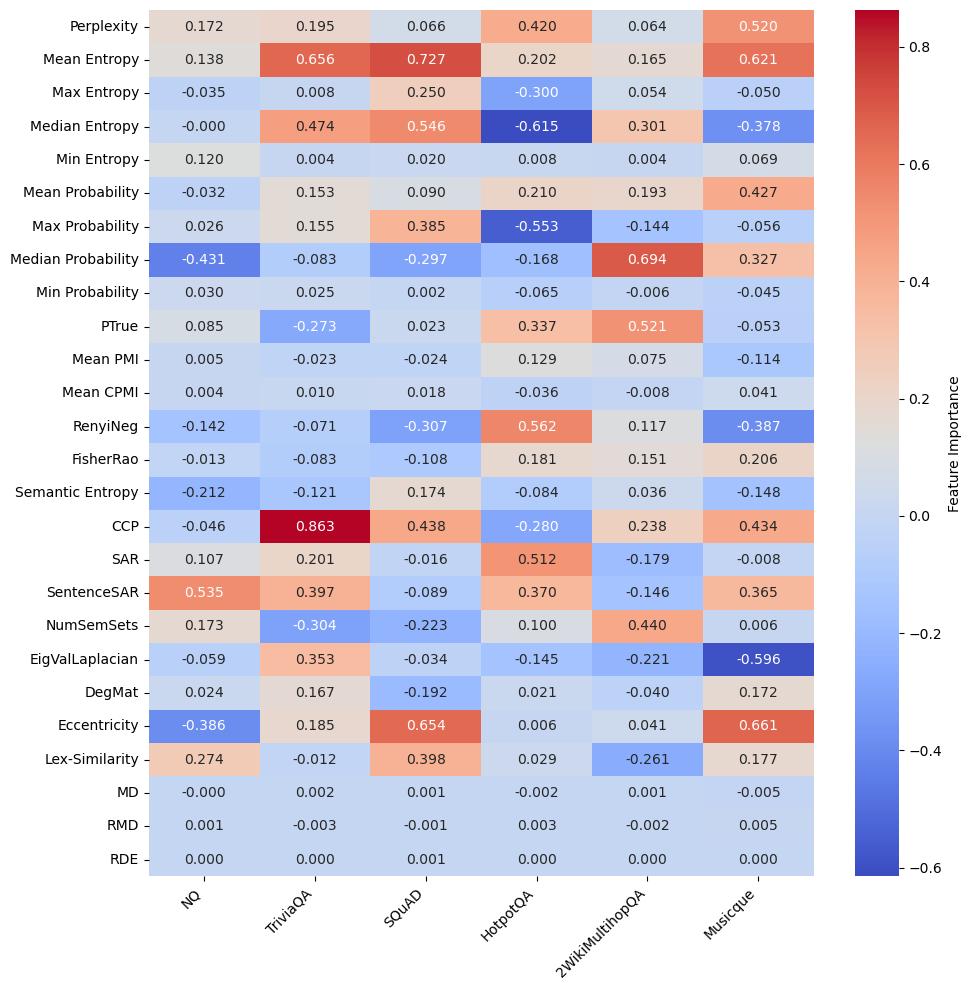

In [14]:
def plot_feature_importance_heatmap(fi_df):
    # Get dataset columns
    dataset_cols = ['s_nq', 's_trivia', 's_squad', 's_hotpotqa', 's_2wikimultihopqa', 's_musique']
    
    # Get feature ranks and order features accordingly
    rank_df = get_feature_rank_df(fi_df)
    feature_order = rank_df['Feature'].tolist()
    
    # Prepare data for heatmap
    heatmap_data = fi_df[['Feature'] + dataset_cols].set_index('Feature')
    heatmap_data = heatmap_data.reindex(feature_order)
    
    # Create figure
    plt.figure(figsize=(10, 10))
    
    # Create heatmap
    sns.heatmap(heatmap_data, 
                # cmap=sns.color_palette("Set2", as_cmap=True),
                cmap=sns.color_palette("coolwarm", as_cmap=True),
                annot=True, 
                fmt='.3f',
                cbar_kws={'label': 'Feature Importance'},
                xticklabels=[DATASET_BEUTIFULL_MAP[col] for col in dataset_cols],
                yticklabels=heatmap_data.index)

    plt.xticks(rotation=45, ha='right')
    plt.ylabel('') 
    plt.tight_layout()
# Plot and save    
plot_feature_importance_heatmap(fi_df)
plt.savefig(f"FI_heatmap.pdf", bbox_inches='tight', dpi=500)
